**7장 앙상블 학습과 랜덤 포레스트**

- 다양한 분류기를 만드는 방법
 1. 각기 다른 훈련 알고리즘 사용
 2. 같은 알고리즘을 사용하고, 훈련 셋트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습


    7.2 배깅과 페이스팅

    - 훈련세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bagging, bootstrap aggregating)
    - 중복을 허용하지 않고 샘플링하는 방식을 페이스팅(pasting) 이라고 한다. 

![image.png](- )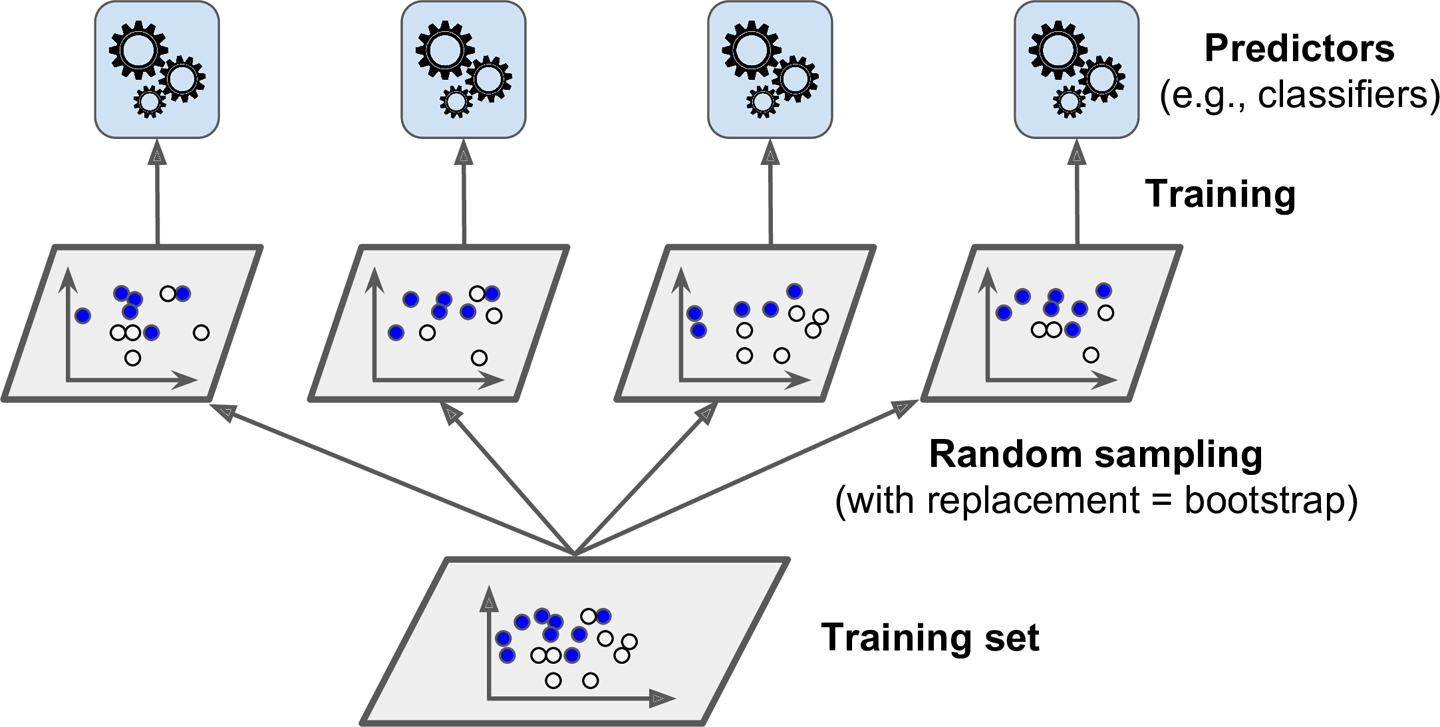

모든 예측기가 훈련을 마치면, 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듭니다. 

설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,   # 앙상블에 사용할 분류기의 수
                            max_samples=100,    # 무작위로 뽑을 샘플의 수 (0~1 로 지정시, 비율)
                            bootstrap=True,     # True: 중복허용(배깅), False: 중복허용X(페이스팅)
                            n_jobs=-1)          # CPU 코어수 지정 (-1: 가용한 모든 코어 사용)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [4]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [5]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


**<그림 7-5. 단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교> 생성 코드**

In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


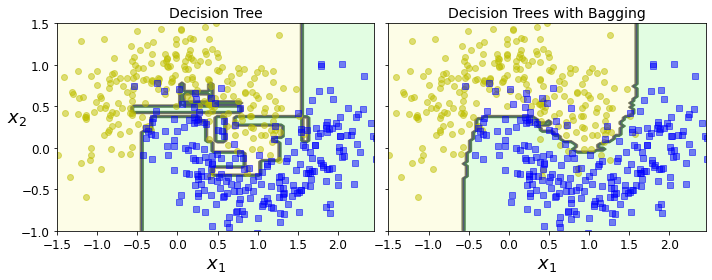

In [8]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

결정경계 시각화 결과, 결정 트리 하나의 예측보다 앙상블의 예측이 일반화가 잘된것을 볼 수 있음

## OOB 평가

- out-of-bag
- bootstrap=True 사용시, 어떤 샘플은 여러번 샘플링되고, 어떤 샘플은 전혀 사용되지 않을 수도 있음
- 선택되지 않은 훈련 샘플의 나머지 37%를 OOB 샘플이라고 부름
- 훈련되는동안 OOB 샘플을 사용하지 않으므로, 검증 세트처럼 사용해 평가 가능

In [9]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            bootstrap=True, 
                            oob_score=True, 
                            random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_ # 500개 결정트리 분류기의 oob 점수를 평균한 값 (90.1%의 정확도)

0.9013333333333333

- oob 평가를 통해 얻은 결정 함수의 값 (범주에 속할 확률)은 oob_decision_function_ 에서 확인 가능

In [12]:
# 총 375(훈련 데이터셋 크기)개 중 10개만
bag_clf.oob_decision_function_[:10]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

(첫번째 훈련 샘플이 양성 범주에 속할 확률을 68.25%, 음성 범주에 속할 확률을 31.74%로 추정)

- 실제 테스트데이터셋과 정확도 비교

In [11]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912